In [1]:
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import gmsh

plt.rcdefaults()
plt.style.use('seaborn-v0_8-paper')
plt.rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

from ttcrpy.tmesh import Mesh2d

# Example 4 - 2D model with circular shapes

In this example, we build and perform traveltime calculations on a 2D model having a circular shape and a hole within.

In [2]:
gmsh.initialize()

gmsh.clear()
mesh_size = 0.3

# points for the surface
p1 = gmsh.model.geo.addPoint(0.0, 0.0, 0.0, meshSize=mesh_size)
p2 = gmsh.model.geo.addPoint(5.0, 0.0, 0.0, meshSize=mesh_size)
p3 = gmsh.model.geo.addPoint(10.0, 0.0, 0.0, meshSize=mesh_size)
p4 = gmsh.model.geo.addPoint(5.0, 0.0, 5.0, meshSize=mesh_size)
p5 = gmsh.model.geo.addPoint(5.0, 0.0, -5.0, meshSize=mesh_size)

# points for the hole
p6 = gmsh.model.geo.addPoint(1.5, 0.0, 0.0, meshSize=mesh_size)
p7 = gmsh.model.geo.addPoint(3.5, 0.0, 0.0, meshSize=mesh_size)
p8 = gmsh.model.geo.addPoint(5.5, 0.0, 0.0, meshSize=mesh_size)
p9 = gmsh.model.geo.addPoint(3.5, 0.0, 2.0, meshSize=mesh_size)
p10 = gmsh.model.geo.addPoint(3.5, 0.0, -2.0, meshSize=mesh_size)

# create arcs
c1 = gmsh.model.geo.addCircleArc(p1, p2, p4, tag=10)
c2 = gmsh.model.geo.addCircleArc(p4, p2, p3, tag=11)
c3 = gmsh.model.geo.addCircleArc(p3, p2, p5, tag=12)
c4 = gmsh.model.geo.addCircleArc(p5, p2, p1, tag=13)

c5 = gmsh.model.geo.addCircleArc(p6, p7, p9, tag=14)
c6 = gmsh.model.geo.addCircleArc(p9, p7, p8, tag=15)
c7 = gmsh.model.geo.addCircleArc(p8, p7, p10, tag=16)
c8 = gmsh.model.geo.addCircleArc(p10, p7, p6, tag=17)

# outer circle
gmsh.model.geo.addCurveLoop([10, 11, 12, 13], tag=20)
# inner circle (hole)
gmsh.model.geo.addCurveLoop([14, 15, 16, 17], tag=21)

gmsh.model.geo.addPlaneSurface([20, 21], tag=30)

gmsh.model.geo.synchronize()

pl1 = gmsh.model.addPhysicalGroup(1, [c1, c2, c3, c4])
ps1 = gmsh.model.addPhysicalGroup(2, [30])

gmsh.model.setPhysicalName(1, pl1, "surface")
gmsh.model.setPhysicalName(2, ps1, "medium")

# We can then generate a 2D mesh...
gmsh.model.mesh.generate(2)

Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 10 (Circle)
Info    : [ 20%] Meshing curve 11 (Circle)
Info    : [ 30%] Meshing curve 12 (Circle)
Info    : [ 40%] Meshing curve 13 (Circle)
Info    : [ 50%] Meshing curve 14 (Circle)
Info    : [ 70%] Meshing curve 15 (Circle)
Info    : [ 80%] Meshing curve 16 (Circle)
Info    : [ 90%] Meshing curve 17 (Circle)
Info    : Done meshing 1D (Wall 0.000410125s, CPU 0.000421s)
Info    : Meshing 2D...
Info    : Meshing surface 30 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0114436s, CPU 0.011088s)
Info    : 1029 nodes 2064 elements


In [3]:
surface = []     # node coordinates at the surface, we will use these as receivers

for dim, tag in gmsh.model.getEntities():
    
    if dim == 1:
        # get the nodes on the arcs
        elemTypes, elemTags, elemNodeTags = gmsh.model.mesh.getElements(dim, tag)
        physicalTags = gmsh.model.getPhysicalGroupsForEntity(dim, tag)
        if len(physicalTags) == 0:
            continue
        name = gmsh.model.getPhysicalName(dim, physicalTags[0])
        
        if name == 'surface':
            for tag in np.unique(elemNodeTags[0]):
                node = gmsh.model.mesh.getNode(tag)
                surface.append(node[0])
surface = np.array(surface)
# keep a subset of nodes
surface = surface[::3, :]

# get indices of nodes forming the triangles of the mesh
triangles = []

tags = gmsh.model.getEntities(dim=2)
elemTypes, elemTags, elemNodeTags = gmsh.model.mesh.getElements(tags[0][0], tags[0][1])
for n in range(len(elemTags[0])):
    t = elemNodeTags[0][3*n:(3*n+3)]
    triangles.append(t)

triangles = np.array(triangles)

uniqueTags = np.unique(triangles)  # we want to store the nodes only once

equiv = np.empty((int(1+uniqueTags.max()),))
nodes = []
for n, tag in enumerate(uniqueTags):
    equiv[tag] = n
    node = gmsh.model.mesh.getNode(tag)
    nodes.append(node[0])

for n1 in range(triangles.shape[0]):
    for n2 in range(triangles.shape[1]):
        triangles[n1, n2] = equiv[triangles[n1, n2]]  # change the tag for the corresponding index
        
nodes = np.array(nodes)   # convert to numpy array
nodes = np.c_[nodes[:, 0], nodes[:, 2]]  # keep only x & z

slowness = np.ones((triangles.shape[0],))
for n1 in range(triangles.shape[0]):
    slowness[n1] += 0.125 * nodes[triangles[n1, 0], 0]  # add a gradient to make things interesting

gmsh.finalize()  # we're done with gmsh

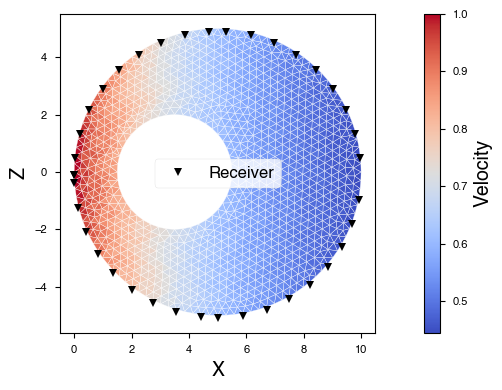

In [4]:
V = 1./slowness  # velocity is more intuitive than slowness

fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)

tpc = ax.tripcolor(nodes[:, 0], nodes[:, 1], triangles, V, cmap='coolwarm', edgecolors='w')
ax.plot(surface[:, 0], surface[:, 2]-0.1, 'kv', label='Receiver')
ax.legend(fontsize=12)
cbar = plt.colorbar(tpc, ax=ax)
cbar.ax.set_ylabel('Velocity', fontsize=14)

ax.set_aspect('equal', 'box')

plt.xlabel('X', fontsize=14)
plt.ylabel('Z', fontsize=14)
plt.tight_layout()
plt.show()

With this kind of geometry and the position of the receivers on the outer circle, we must use the Shortest Path Method (SPM) to ensure that raypaths stay inside the mesh (see https://ttcrpy.readthedocs.io/en/latest/algorithms.html#computing-traveltimes-from-raypaths ). 

In [5]:
Tx = np.array([[8.0, 2.0]])  # place a source at an arbitrary position
Rx = surface[:, ::2]

# create the mesh (values in trangles are unsigned long, we must pass int)
mesh = Mesh2d(nodes, triangles.astype(np.int64), method='SPM', n_secondary=10)

# we can now compute traveltimes and raypaths
tt, rays = mesh.raytrace(Tx, Rx, slowness, return_rays=True)

/var/folders/kd/v1qqm8qd15506q5jp_2tz_bw0000gn/T/ipykernel_47189/1377281946.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  tt, rays = mesh.raytrace(Tx, Rx, slowness, return_rays=True)


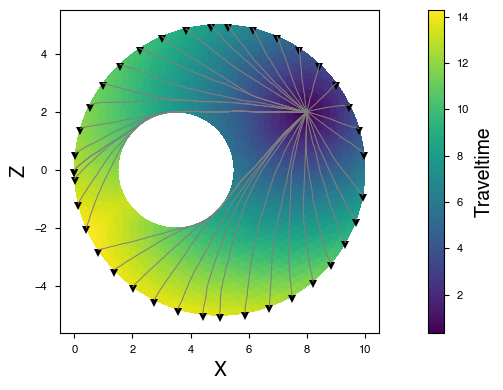

In [6]:
# let's first retrieve traveltimes at the nodes of the mesh for display purposes
mesh_tt = mesh.get_grid_traveltimes()

fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)

tpc = ax.tripcolor(nodes[:, 0], nodes[:, 1], triangles, mesh_tt)
ax.plot(surface[:, 0], surface[:, 2]-0.1, 'kv')

# add rays for the receivers at the surface
nRx = surface.shape[0]
for r in rays[:nRx]:
    plt.plot(r[:,0], r[:,1], c=[0.5, 0.5, 0.5], lw=0.75)
    
ax.set_aspect('equal', 'box')

cbar = plt.colorbar(tpc, ax=ax)
cbar.ax.set_ylabel('Traveltime', fontsize=14)

plt.xlabel('X', fontsize=14)
plt.ylabel('Z', fontsize=14)
plt.tight_layout()
plt.show()

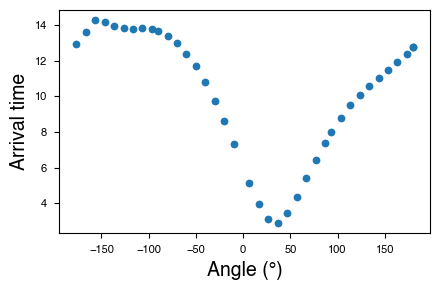

In [7]:
# position of receiver in terms of angle w/r to the center of tha main circle

theta = 180/np.pi*np.arctan2(Rx[:, 1], Rx[:, 0]-5)

plt.figure(figsize=(4.5,3))
plt.plot(theta, tt, 'o')

plt.xlabel('Angle (°)', fontsize=14)
plt.ylabel('Arrival time', fontsize=14)
plt.tight_layout()
plt.show()